In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
dt = 0.001
T = 1
runs = 50

### Adjacency Matrix

In [3]:
graphs = {}

# default, connected
A = np.ones((n,n))
A = np.triu(A, 1)
A = A + A.T

graphs['default'] = A

# Erdos Renyi
p = .2
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

graphs['erdos'] = A

# Small World
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        if np.abs(i-j) < 5:
            A[i,j] = 1
        elif np.abs(i-j) > n-5:
            A[i,j] = 1
        else:
            A[i,j] = 0

graphs['small-world'] = A

# # Barbell
# pop = np.random.randint(25,75) #minimum and maximum population sizes
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             A[i,j] = 0
#         elif (i <= pop and j <= pop) or (i > pop and j > pop):
#             A[i,j] = 1
#         else:
#             A[i,j] = 0
# sender = np.random.randint(0,pop+1)
# receiver = np.random.randint(pop+1,99)
# A[sender,receiver] = 1
# A[receiver,sender] = 1

# graphs['barbell'] = A

### Information Accumulation Process & Kick Weight

In [4]:
mu = np.ones(n) # diffusion, i.e. correct decision
W = lambda: np.random.randn(n) # drift, randon Weiner process

def dydt(A, zeta, mu, w, kicks, dt):
    """Information Accumulation Model
    Args:
        A (nxn): adjacency matrix
        zeta (nx1): drift at current time
        mu (nx1): diffusion
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dydt
    """
    return (mu*dt + np.sqrt(2)*zeta*np.sqrt(dt)) + w*A.dot(kicks)

def dwdt(A, kappa, gamma, w, kicks, dt,tau = 1):
    """Kick weights
    Args:
        A (nxn): adjacency matrix
        kappa (nx1): learning rate
        gamma (nx1): forgetting rate
        w (nx1): update weights
        kicks (nx1): kick at current time
        dt (float): time step
    Returns:
        np.ndarray: dwdt
    """
    return (kappa - w)*dt/tau - gamma*w*np.where(A.dot(np.abs(kicks)) > 1, 1, A.dot(np.abs(kicks)))

def RR(y,tstop,correct=1): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = np.sum(y[:,tstop] == correct*np.inf)
    return (cor/len(y[:,tstop]))/tstop

### Simulation

In [5]:
def sim(A,kappa,gamma,tau,theta,stopcondition=1,function="theta"):
    # initial conditions
    y = np.zeros((n, int(T/dt)))
    w = np.zeros((n, int(T/dt)))

    # initial kick
    kicks = np.zeros(n)

    tstop=int(T/dt)-1

    # simulation
    for t in range(int(T/dt)-1):
        # drift
        zeta = W()
        # update state
        y[:,t+1] = y[:,t] + dydt(A, zeta, mu, w[:,t], kicks, dt)
        # update kick weights
        if function=="theta" or function=="shark":
            w[:,t+1] = w[:,t] + dwdt(A, kappa, gamma, w[:,t], kicks, dt,tau)
        elif function == 1:
            w[:,t+1] = 1
        # update kick
        kp = np.where(y[:,t+1] < np.inf, y[:,t+1], 0) 
        kp = np.where(kp > theta, kp, 0) # TODO this was mu, how to make everything work when we change it? Necessary?
        km = np.where(y[:,t+1] > -np.inf, y[:,t+1], 0)
        km = np.where(km < -theta, km, 0) # TODO this was mu, how to make everything work when we change it? Necessary?
        kicks = kp - km if function=="theta" else np.where(kp, 1, 0) - np.where(km, 1, 0)
        # set to inf
        y[:,t+1] = np.where(y[:,t+1] > theta, np.inf, y[:,t+1])
        y[:,t+1] = np.where(y[:,t+1] < -theta, -np.inf, y[:,t+1])
        # stop condition
        if (np.sum(y[:,t+1] == np.inf) + np.sum(y[:,t+1] == -np.inf))/len(y[:,t+1]) >= stopcondition:
            tstop = t+1
            break

    return RR(y,tstop), np.sum(y[:,tstop] == np.inf), np.sum(y[:,tstop] == -np.inf), tstop, y, w

In [6]:
# run multiple sims and return average rr and acc
def run(runs,A,kappa,gamma,tau,lower,stopcondition=.9,function="theta"):
    rrthis = []
    corthis = []
    for _ in range(runs):
        theta = np.array([np.random.uniform(lower,1) for _ in range(n)]) # thresholds
        rr, cor, _, _, _, _ = sim(A,kappa,gamma,tau,theta,stopcondition,function)
        rrthis.append(rr)
        corthis.append(cor)
    return np.average(rrthis), np.average(corthis)

In [7]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
def gradient_descent(runs, A, kappa, gamma, tau, lower, stopcondition=.9, function="theta", alpha=.01, iterations=100):
    for i in range(iterations):
        rr, cor  = run(runs, A, kappa, gamma, tau, lower, stopcondition, function)
        if i % 10 == 0:
            print(rr, cor)
        if rr == 0:
            break
        # calculate gradients
        gradkappa = (run(runs,A, kappa+alpha, gamma, tau, lower, stopcondition, function)[0] - rr)/alpha
        gradgamma = (run(runs, A,kappa, gamma+alpha, tau, lower, stopcondition, function)[0] - rr)/alpha
        # update parameters
        kappa = kappa - alpha*gradkappa
        gamma = gamma - alpha*gradgamma
    return kappa, gamma, tau

#### Small sim

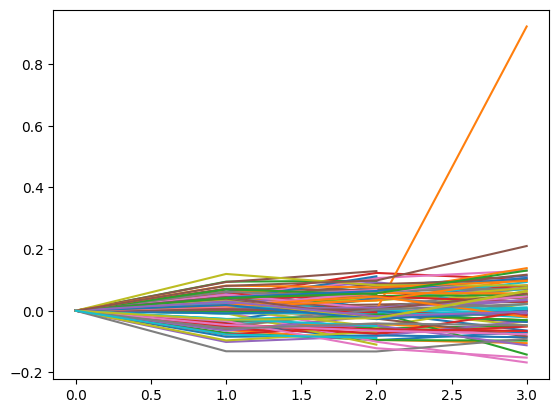

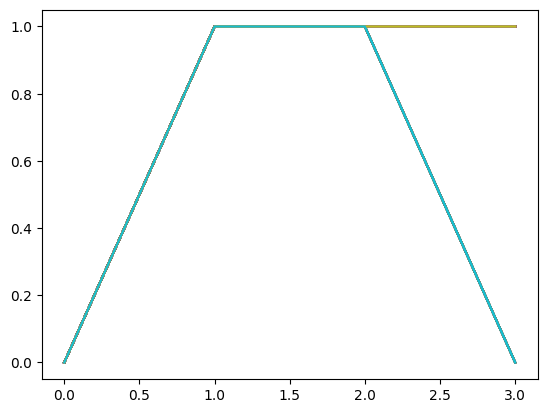

0.245 98 0


In [8]:
theta = np.array([np.random.uniform(.1,1) for _ in range(n)]) # thresholds
rr, cor, inc, tstop, yv, wv = sim(graphs['erdos'], 1,1,.001,theta,stopcondition=.9,function="shark")
plt.plot(yv[:,:tstop].T)
plt.show()
plt.plot(wv[:,:tstop].T)
plt.show()
print(rr, cor, inc)

## Big Sims

In [9]:
# plot dots for rr and acc over an x axis
def plotting(input, mean, axis, xlabel, ylabel, title, logscale=False):
    # plt.scatter(axis, input, alpha=.1)
    # fill between the 25th and 75th percentile
    plt.fill_between(axis, np.quantile(input, .25, axis=1), np.quantile(input, .75, axis=1), alpha=.2)
    plt.plot(axis, mean)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logscale: plt.xscale('log')
    plt.title(title)
    plt.show()

# function to plot over lower theta
def plotLowerTheta(runs, A, kappa, gamma, tau, lower, stopcondition=.9, functions=["theta",0]):
    th = {str(a): [] for a in functions}
    rr = {str(a): [] for a in functions}
    rrm = {str(a): [] for a in functions}
    cor = {str(a): [] for a in functions}
    corm = {str(a): [] for a in functions}
    for l in np.linspace(lower,1,20):
        rrt = {str(a): [] for a in functions}
        cort = {str(a): [] for a in functions}
        for _ in range(runs):
            theta = np.array([np.random.uniform(l,1) for _ in range(n)])
            for f in functions:
                rrtt, cortt, _, _, _, _ = sim(A,kappa,gamma,tau,theta,stopcondition,f)
                rrt[str(f)].append(rrtt)
                cort[str(f)].append(cortt)
        for f in functions:
            th[str(f)].append([l for _ in range(runs)])
            rr[str(f)].append(rrt[str(f)])
            rrm[str(f)].append(np.average(rrt[str(f)]))
            cor[str(f)].append(cort[str(f)])
            corm[str(f)].append(np.average(cort[str(f)]))
    return th, rr, rrm, cor, corm

### Connected

In [10]:
# Erdos Renyi
p = 1
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

In [11]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
ktheta, gtheta, ttheta = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="theta", alpha=.01, iterations=100)
print(ktheta, gtheta, ttheta)
kshark, gshark, tshark = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="shark", alpha=.01, iterations=100)
print(kshark, gshark, tshark)

0.18540103896103893 98.84
0.186012619047619 99.4
0.19468682539682539 98.88
0.19299984848484855 98.94
0.18901532467532467 99.28
0.19971619047619046 99.04
0.1889240476190476 99.22
0.18669428571428573 99.12
0.189895 99.12
0.191503088023088 99.08
0.9455781973255503 0.9872304656454665 0.001
0.11891821067821068 54.0
0.09804484126984127 47.22
0.09445031746031747 47.84
0.09472095238095238 48.02
0.08643714285714285 50.02
0.09970888167388167 49.9
0.09172571428571429 43.64
0.09836475468975468 49.62
0.12361666666666668 61.66
0.08017143578643578 43.7
0.4917371734216936 0.719330415084326 0.001


In [12]:
# plot over lower theta
th, rr, rrm, cor, corm = plotLowerTheta(runs, A, ktheta, gtheta, ttheta, .1, stopcondition=.9, functions=["theta","shark",0,1])
th = {str(a): np.linspace(.1,1,20) for a in ["theta","shark",0,1]}

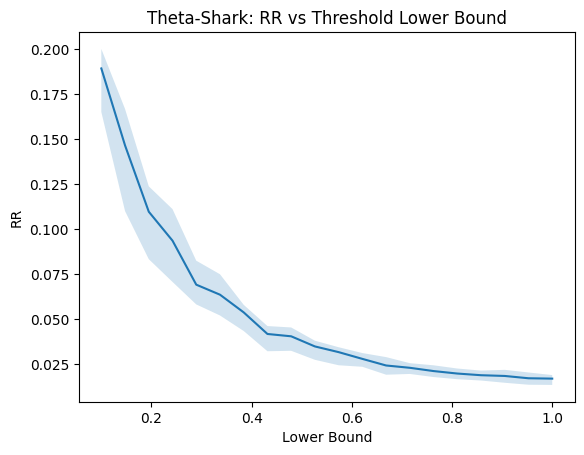

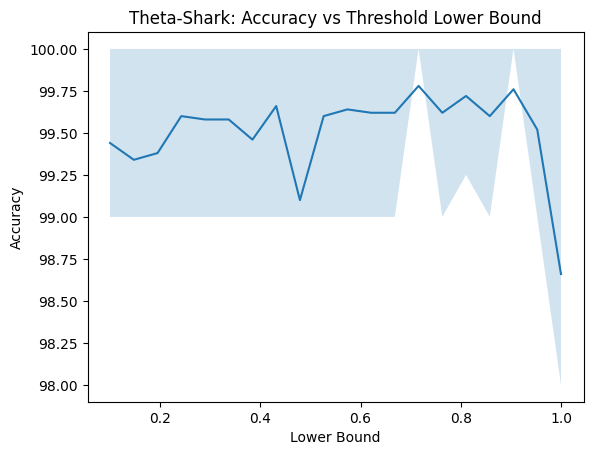

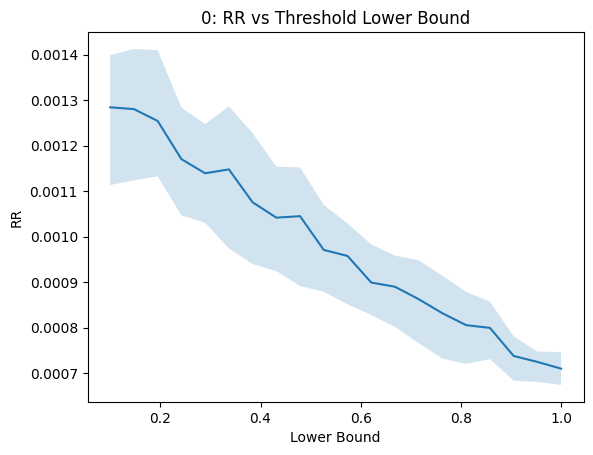

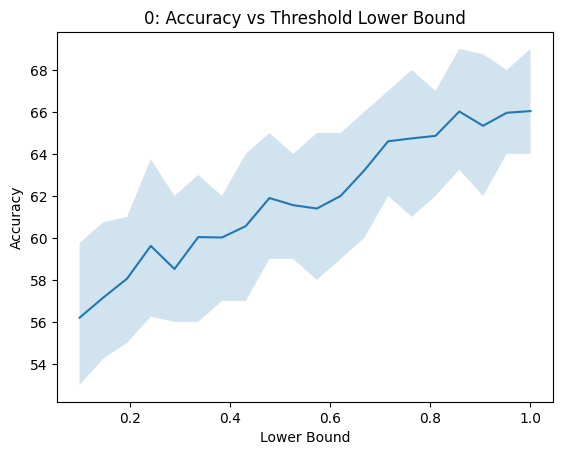

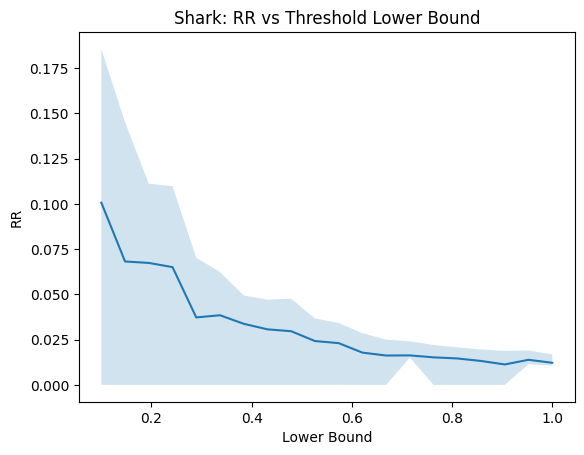

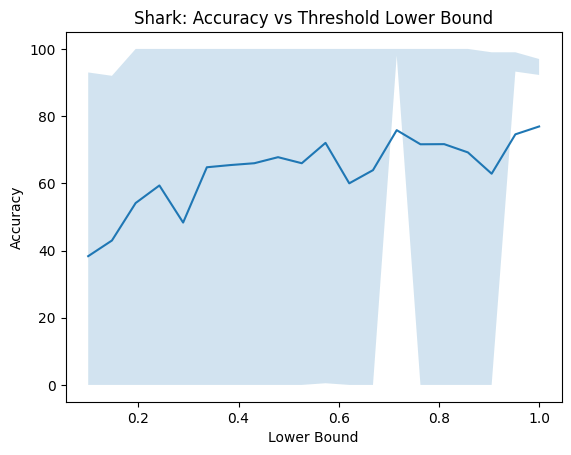

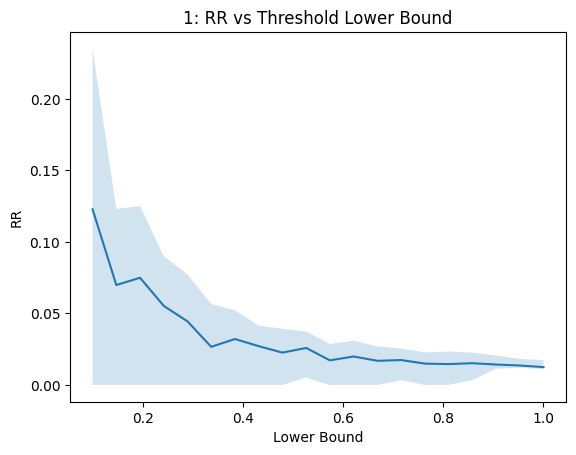

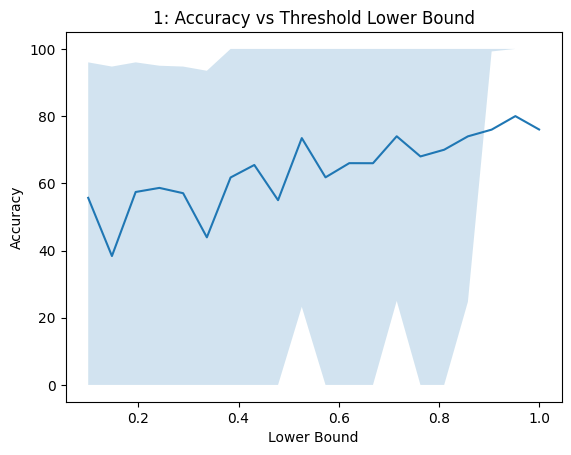

In [13]:
plotting(rr["theta"], rrm["theta"], np.linspace(.1,1,20), "Lower Bound", "RR", "Theta-Shark: RR vs Threshold Lower Bound")
plotting(cor["theta"], corm["theta"], th["theta"], "Lower Bound", "Accuracy", "Theta-Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["0"], rrm["0"], th["0"], "Lower Bound", "RR", "0: RR vs Threshold Lower Bound")
plotting(cor["0"], corm["0"], th["0"], "Lower Bound", "Accuracy", "0: Accuracy vs Threshold Lower Bound")

plotting(rr["shark"], rrm["shark"], th["shark"], "Lower Bound", "RR", "Shark: RR vs Threshold Lower Bound")
plotting(cor["shark"], corm["shark"], th["shark"], "Lower Bound", "Accuracy", "Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["1"], rrm["1"], th["1"], "Lower Bound", "RR", "1: RR vs Threshold Lower Bound")
plotting(cor["1"], corm["1"], th["1"], "Lower Bound", "Accuracy", "1: Accuracy vs Threshold Lower Bound")

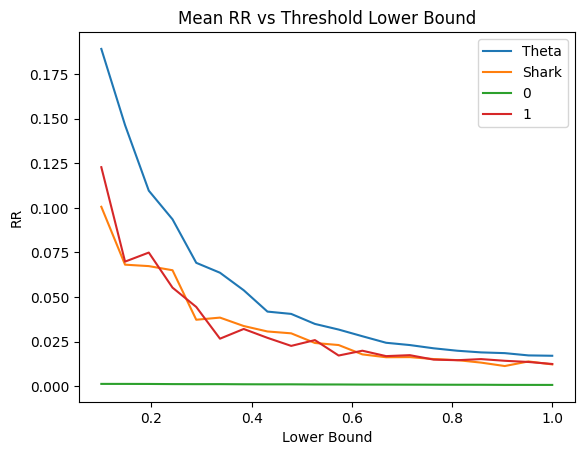

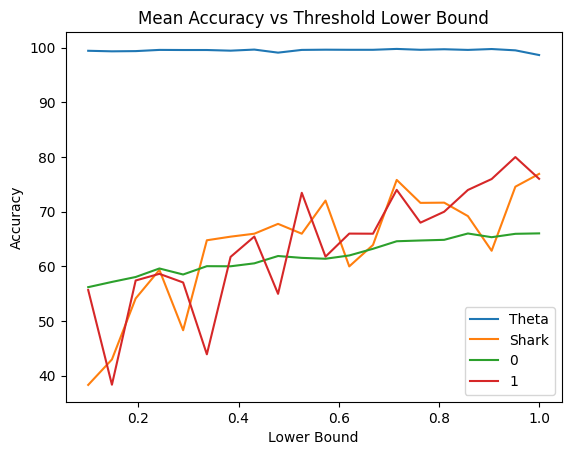

In [14]:
# plot all mean rr and acc lines
plt.plot(np.linspace(.1,1,20), rrm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), rrm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), rrm["0"], label="0")
plt.plot(np.linspace(.1,1,20), rrm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("RR")
plt.title("Mean RR vs Threshold Lower Bound")
plt.legend()
plt.show()

plt.plot(np.linspace(.1,1,20), corm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), corm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), corm["0"], label="0")
plt.plot(np.linspace(.1,1,20), corm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy vs Threshold Lower Bound")
plt.legend()
plt.show()


### Erdos-Renyi

In [15]:
# Erdos Renyi
p = .2
A = np.random.rand(n,n) # random matrix
A = np.where(A < p, 1, 0) # adjacency matrix
A = np.triu(A, 1) # triangular matrix
A = A + A.T # symmetric matrix

In [16]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
ktheta, gtheta, ttheta = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="theta", alpha=.01, iterations=100)
print(ktheta, gtheta, ttheta)
kshark, gshark, tshark = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="shark", alpha=.01, iterations=100)
print(kshark, gshark, tshark)

0.13440093795093797 97.18
0.1405492207792208 97.4
0.13330007936507937 98.02
0.1329543650793651 97.52
0.13261041125541126 96.48
0.13424118437118437 96.56
0.13566988788988787 96.34
0.12774748917748918 98.0
0.1378381313131313 96.86
0.12818209235209235 97.14
0.9498807259407256 1.0088781783739136 0.001
0.1020684199134199 53.46
0.10728566544566545 60.1
0.09929103174603174 51.0
0.11441992063492062 59.6
0.09832589133089131 49.78
0.10483170274170274 53.46
0.11087880952380955 56.3
0.09305108669108669 46.88
0.11552571428571427 59.3
0.11388142857142858 56.56
0.9761341669441674 1.1721638389388385 0.001


In [17]:
# plot over lower theta
th, rr, rrm, cor, corm = plotLowerTheta(runs, A, ktheta, gtheta, ttheta, .1, stopcondition=.9, functions=["theta","shark",0,1])
th = {str(a): np.linspace(.1,1,20) for a in ["theta","shark",0,1]}

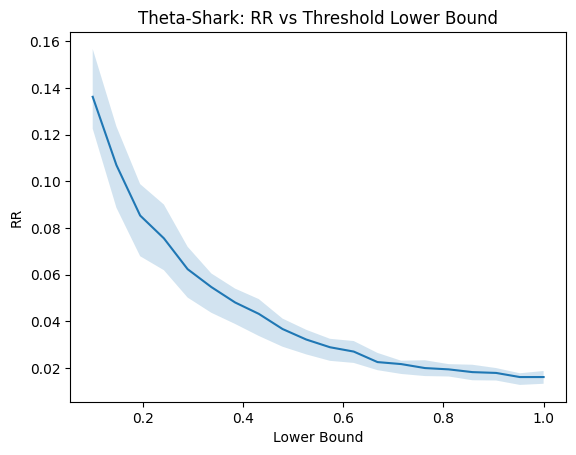

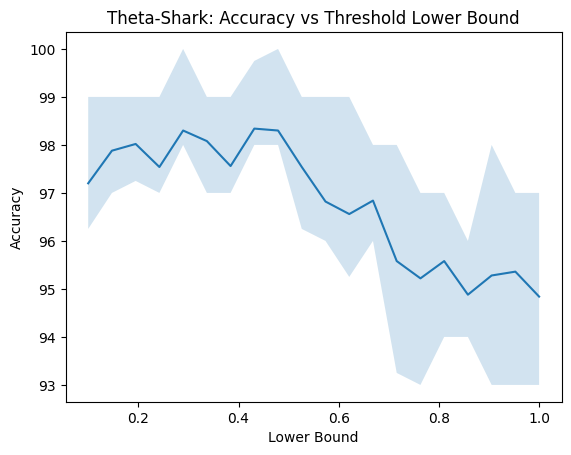

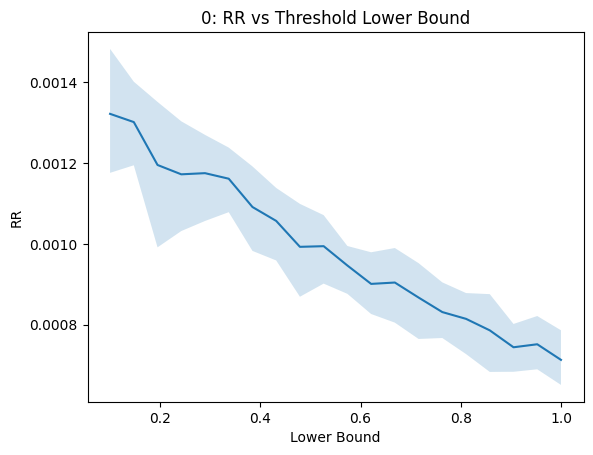

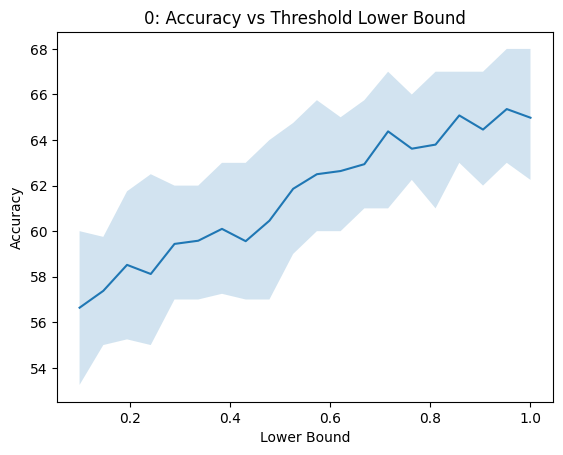

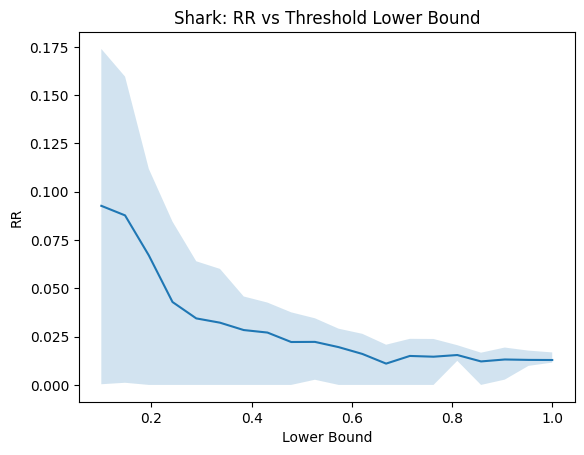

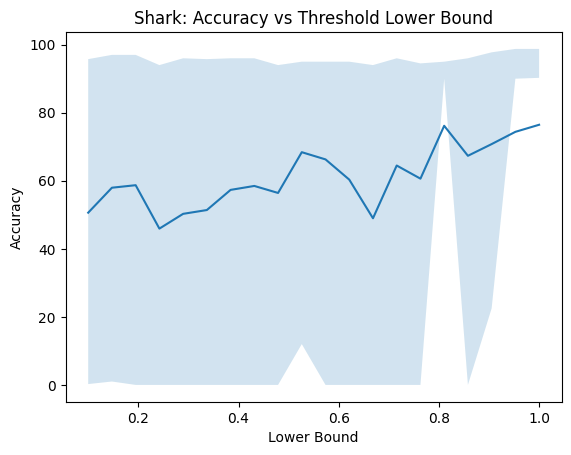

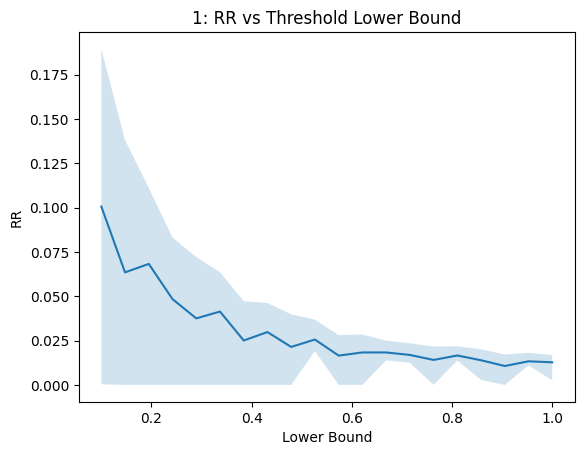

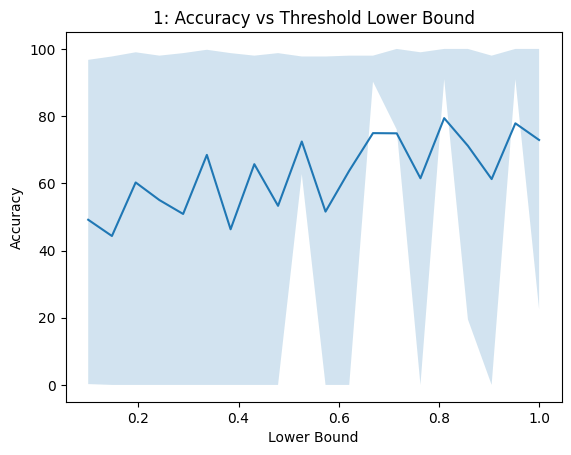

In [18]:
plotting(rr["theta"], rrm["theta"], th["theta"], "Lower Bound", "RR", "Theta-Shark: RR vs Threshold Lower Bound")
plotting(cor["theta"], corm["theta"], th["theta"], "Lower Bound", "Accuracy", "Theta-Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["0"], rrm["0"], th["0"], "Lower Bound", "RR", "0: RR vs Threshold Lower Bound")
plotting(cor["0"], corm["0"], th["0"], "Lower Bound", "Accuracy", "0: Accuracy vs Threshold Lower Bound")

plotting(rr["shark"], rrm["shark"], th["shark"], "Lower Bound", "RR", "Shark: RR vs Threshold Lower Bound")
plotting(cor["shark"], corm["shark"], th["shark"], "Lower Bound", "Accuracy", "Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["1"], rrm["1"], th["1"], "Lower Bound", "RR", "1: RR vs Threshold Lower Bound")
plotting(cor["1"], corm["1"], th["1"], "Lower Bound", "Accuracy", "1: Accuracy vs Threshold Lower Bound")

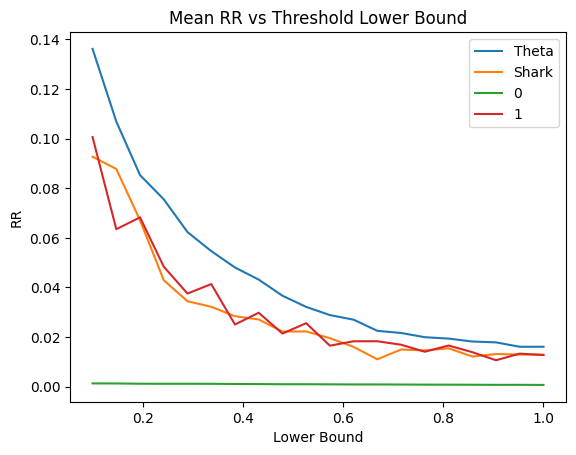

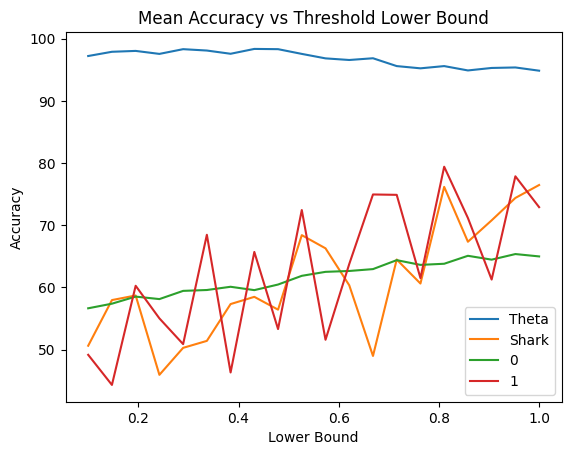

In [19]:
# plot all mean rr and acc lines
plt.plot(np.linspace(.1,1,20), rrm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), rrm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), rrm["0"], label="0")
plt.plot(np.linspace(.1,1,20), rrm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("RR")
plt.title("Mean RR vs Threshold Lower Bound")
plt.legend()
plt.show()

plt.plot(np.linspace(.1,1,20), corm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), corm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), corm["0"], label="0")
plt.plot(np.linspace(.1,1,20), corm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy vs Threshold Lower Bound")
plt.legend()
plt.show()


In [20]:
# function to plot over p
def plotPValues(runs, A, kappa, gamma, tau, lower, stopcondition=.9, functions=["theta",0]):
    pv = {str(a): [] for a in functions}
    rr = {str(a): [] for a in functions}
    rrm = {str(a): [] for a in functions}
    cor = {str(a): [] for a in functions}
    corm = {str(a): [] for a in functions}
    for p in [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1]:
        rrt = {str(a): [] for a in functions}
        cort = {str(a): [] for a in functions}
        for _ in range(runs):
            A = np.random.rand(n,n) # random matrix
            A = np.where(A < p, 1, 0) # adjacency matrix
            A = np.triu(A, 1) # triangular matrix
            A = A + A.T # symmetric matrix
            for f in functions:
                rrtt, cortt, _, _, _, _ = sim(A,kappa,gamma,tau,theta,stopcondition,f)
                rrt[str(f)].append(rrtt)
                cort[str(f)].append(cortt)
        for f in functions:
            pv[str(f)].append([p for _ in range(runs)])
            rr[str(f)].append(rrt[str(f)])
            rrm[str(f)].append(np.average(rrt[str(f)]))
            cor[str(f)].append(cort[str(f)])
            corm[str(f)].append(np.average(cort[str(f)]))
    return pv, rr, rrm, cor, corm

In [21]:
# plot over p values
pv, rr, rrm, cor, corm = plotPValues(runs, A, ktheta, gtheta, ttheta, .1, stopcondition=.9, functions=["theta","shark",0,1])
pv = {str(a): [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1] for a in ["theta","shark",0,1]}

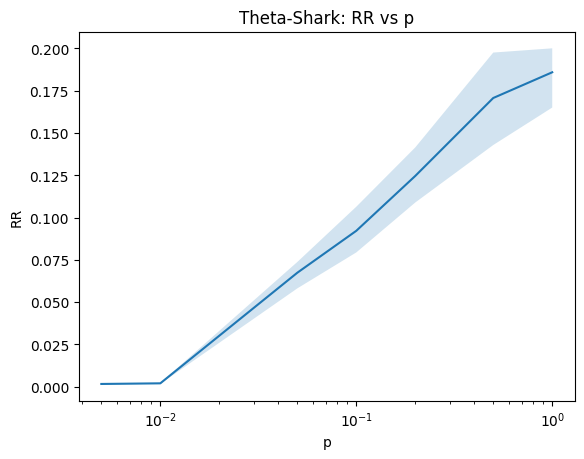

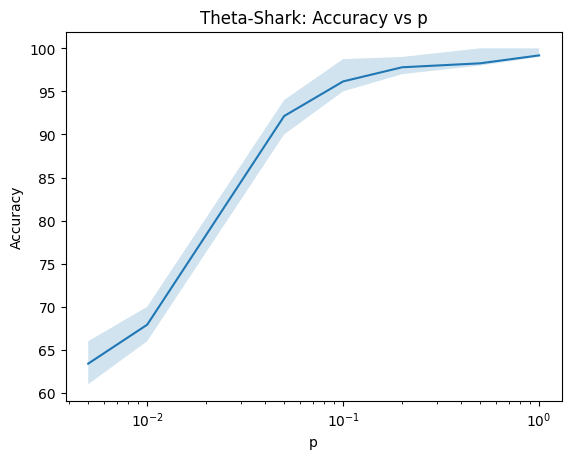

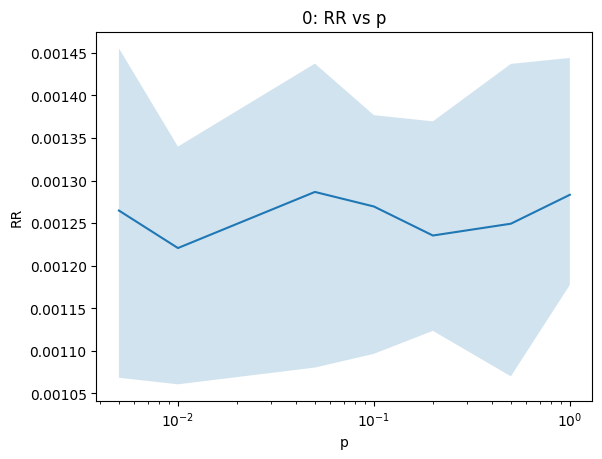

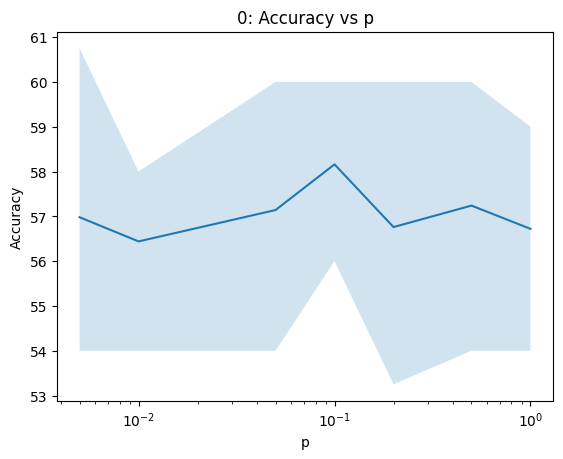

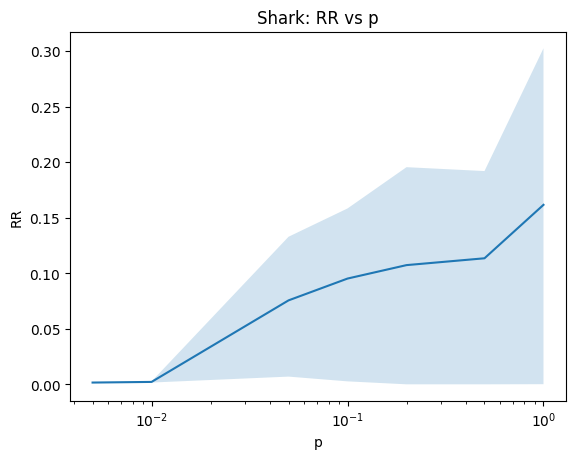

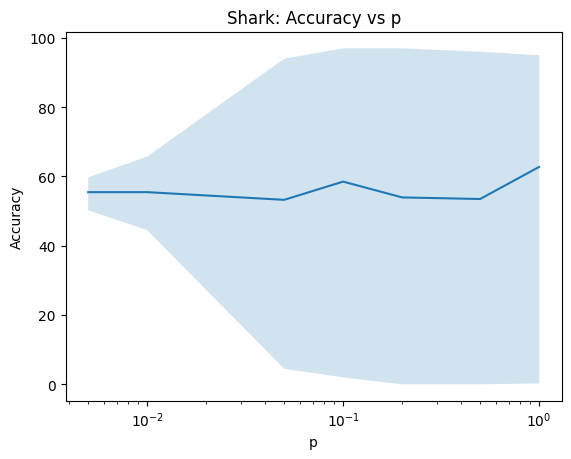

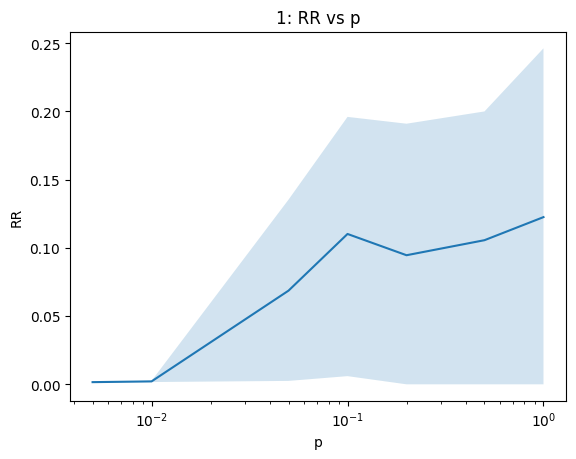

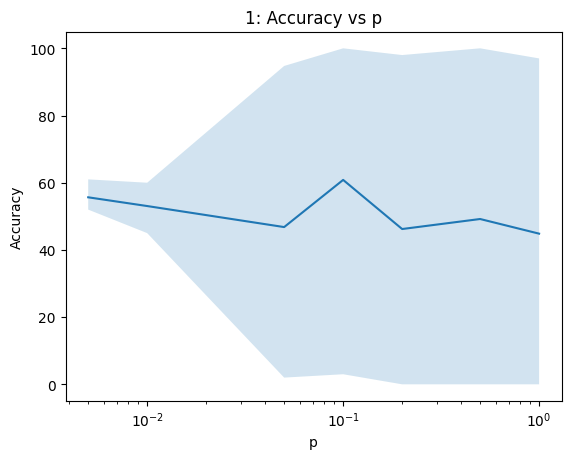

In [22]:
plotting(rr["theta"], np.average(rr["theta"], axis=1), pv["theta"], "p", "RR", "Theta-Shark: RR vs p", logscale=True)
plotting(cor["theta"], np.average(cor["theta"], axis=1), pv["theta"], "p", "Accuracy", "Theta-Shark: Accuracy vs p", logscale=True)

plotting(rr["0"], np.average(rr["0"], axis=1), pv["0"], "p", "RR", "0: RR vs p", logscale=True)
plotting(cor["0"], np.average(cor["0"], axis=1), pv["0"], "p", "Accuracy", "0: Accuracy vs p", logscale=True)

plotting(rr["shark"], np.average(rr["shark"], axis=1), pv["shark"], "p", "RR", "Shark: RR vs p", logscale=True)
plotting(cor["shark"], np.average(cor["shark"], axis=1), pv["shark"], "p", "Accuracy", "Shark: Accuracy vs p", logscale=True)

plotting(rr["1"], np.average(rr["1"], axis=1), pv["1"], "p", "RR", "1: RR vs p", logscale=True)
plotting(cor["1"], np.average(cor["1"], axis=1), pv["1"], "p", "Accuracy", "1: Accuracy vs p", logscale=True)

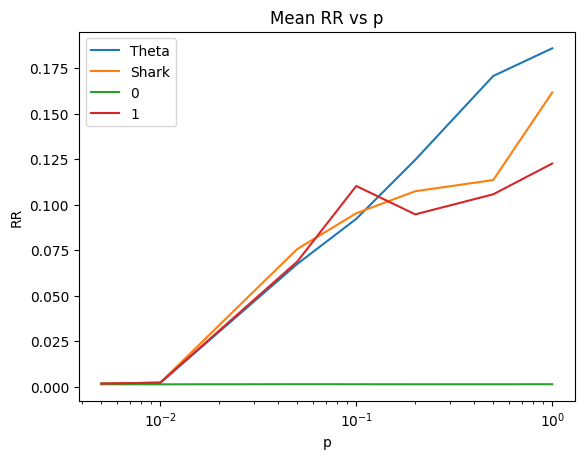

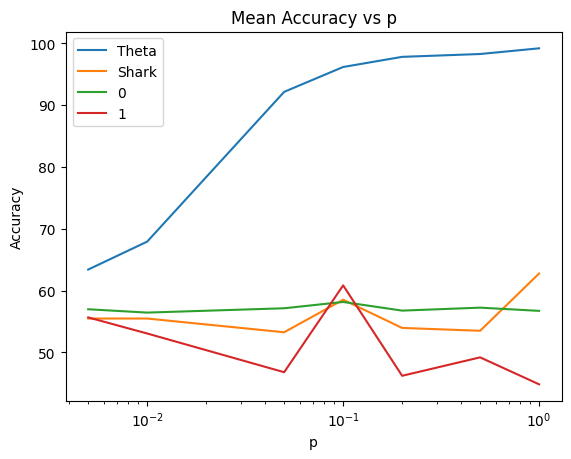

In [23]:
# plot all mean rr and acc lines
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(rr["theta"], axis=1), label="Theta")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(rr["shark"], axis=1), label="Shark")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(rr["0"], axis=1), label="0")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(rr["1"], axis=1), label="1")
plt.xlabel("p")
plt.ylabel("RR")
plt.xscale('log')
plt.title("Mean RR vs p")
plt.legend()
plt.show()

plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(cor["theta"], axis=1), label="Theta")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(cor["shark"], axis=1), label="Shark")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(cor["0"], axis=1), label="0")
plt.plot([0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1], np.average(cor["1"], axis=1), label="1")
plt.xlabel("p")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.title("Mean Accuracy vs p")
plt.legend()

### Small World

In [24]:
# Small World
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        if np.abs(i-j) < 5:
            A[i,j] = 1
        elif np.abs(i-j) > n-5:
            A[i,j] = 1
        else:
            A[i,j] = 0

In [25]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
ktheta, gtheta, ttheta = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="theta", alpha=.01, iterations=100)
print(ktheta, gtheta, ttheta)
kshark, gshark, tshark = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="shark", alpha=.01, iterations=100)
print(kshark, gshark, tshark)

0.06323824524804401 92.46
0.06827121367710377 91.28
0.0682196662161368 92.14
0.06577409209727322 91.4
0.06413356408469412 91.06
0.067436624797631 91.6
0.06458600267465592 91.18
0.06683280498912851 92.12
0.06474755359535546 90.68
0.06616218715752771 91.26
0.9885131544427659 1.0020944730022971 0.001
0.05000927072927072 50.92
0.054980563325563316 54.94
0.04721615440115441 47.04
0.049420829725829736 48.02
0.05321963660522484 51.3
0.0517829032079032 51.86
0.04561569574216634 48.76
0.05561803862803862 55.58
0.05030336913086912 52.02
0.041462952602952595 43.86
0.9460666487614546 1.0154669015642082 0.001


In [26]:
# plot over lower theta
th, rr, rrm, cor, corm = plotLowerTheta(runs, A, ktheta, gtheta, ttheta, .1, stopcondition=.9, functions=["theta","shark",0,1])
th = {str(a): np.linspace(.1,1,20) for a in ["theta","shark",0,1]}

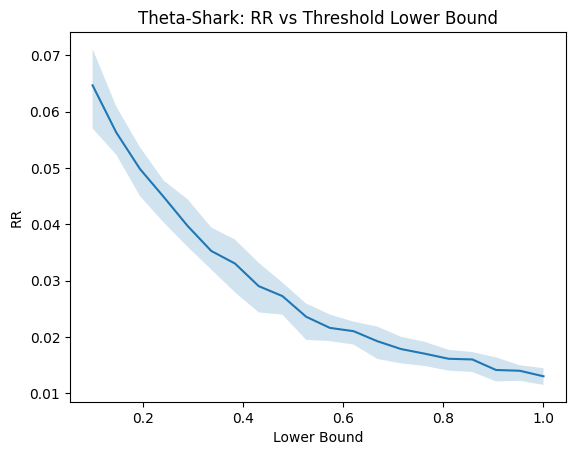

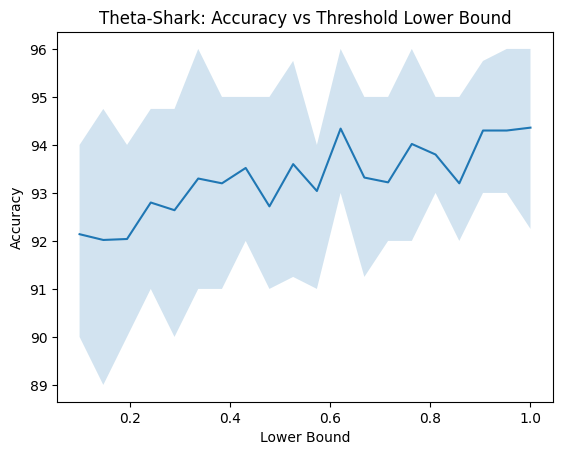

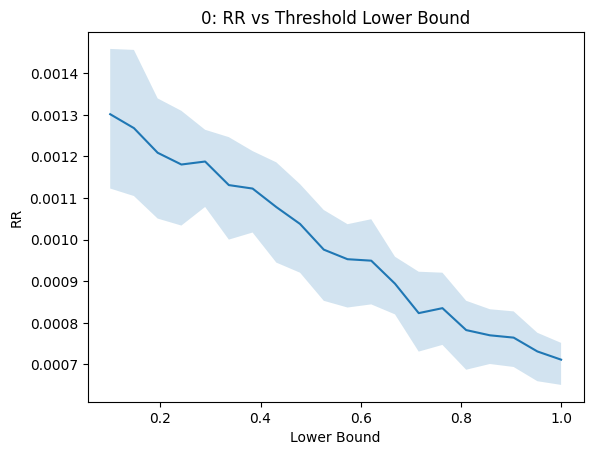

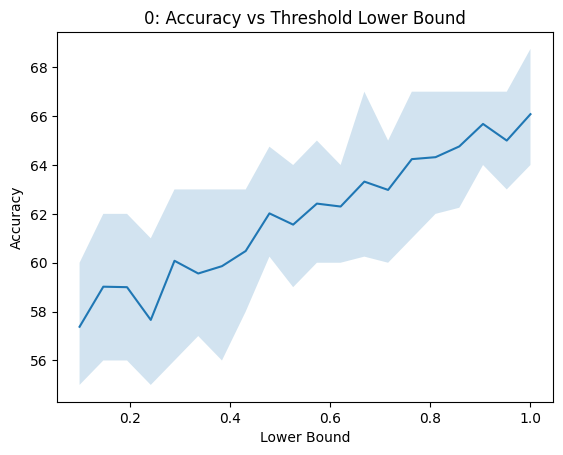

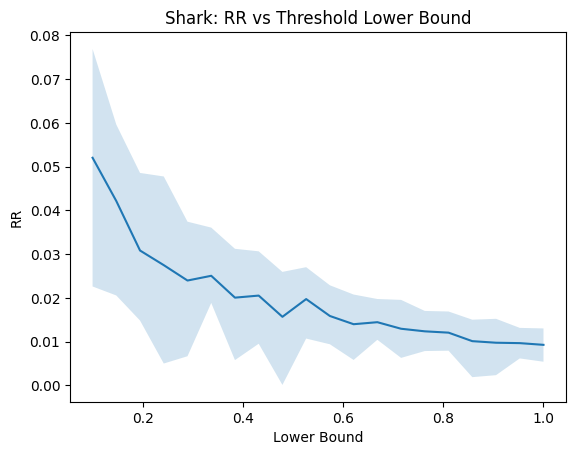

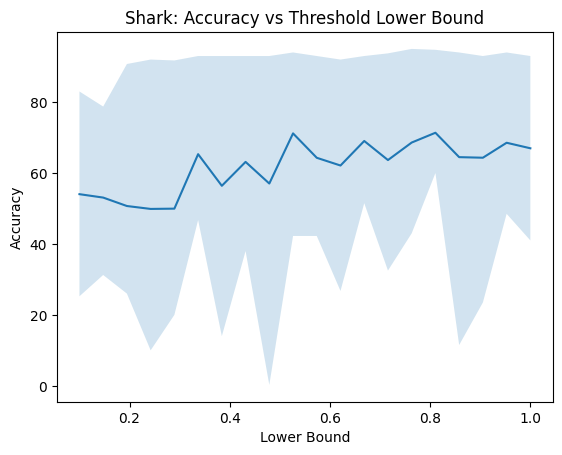

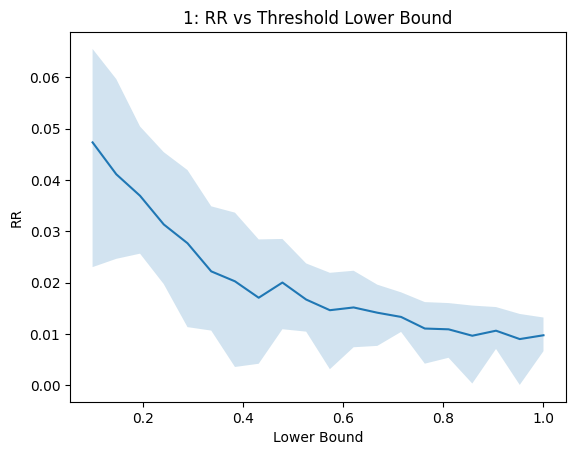

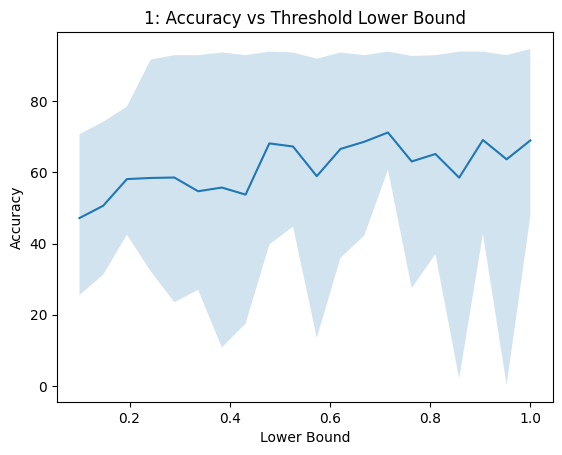

In [27]:
plotting(rr["theta"], rrm["theta"], th["theta"], "Lower Bound", "RR", "Theta-Shark: RR vs Threshold Lower Bound")
plotting(cor["theta"], corm["theta"], th["theta"], "Lower Bound", "Accuracy", "Theta-Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["0"], rrm["0"], th["0"], "Lower Bound", "RR", "0: RR vs Threshold Lower Bound")
plotting(cor["0"], corm["0"], th["0"], "Lower Bound", "Accuracy", "0: Accuracy vs Threshold Lower Bound")

plotting(rr["shark"], rrm["shark"], th["shark"], "Lower Bound", "RR", "Shark: RR vs Threshold Lower Bound")
plotting(cor["shark"], corm["shark"], th["shark"], "Lower Bound", "Accuracy", "Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["1"], rrm["1"], th["1"], "Lower Bound", "RR", "1: RR vs Threshold Lower Bound")
plotting(cor["1"], corm["1"], th["1"], "Lower Bound", "Accuracy", "1: Accuracy vs Threshold Lower Bound")

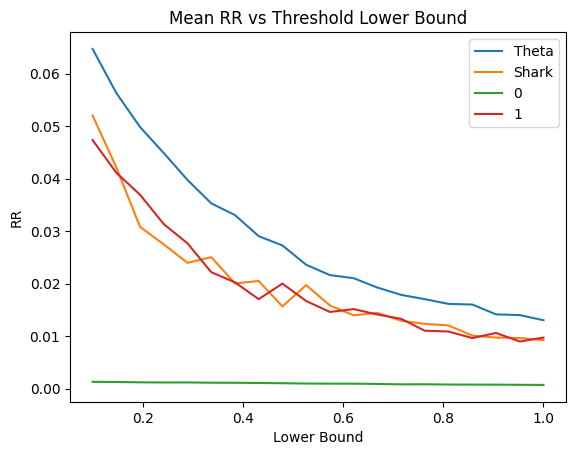

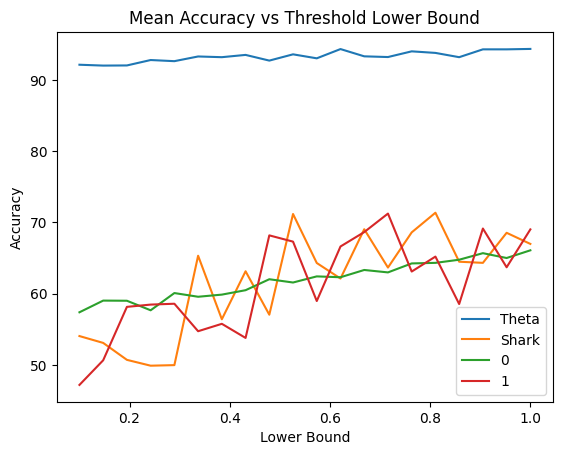

In [28]:
# plot all mean rr and acc lines
plt.plot(np.linspace(.1,1,20), rrm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), rrm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), rrm["0"], label="0")
plt.plot(np.linspace(.1,1,20), rrm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("RR")
plt.title("Mean RR vs Threshold Lower Bound")
plt.legend()
plt.show()

plt.plot(np.linspace(.1,1,20), corm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), corm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), corm["0"], label="0")
plt.plot(np.linspace(.1,1,20), corm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy vs Threshold Lower Bound")
plt.legend()
plt.show()


### Barbell

In [29]:
# Barbell
pop = np.random.randint(25,75) #minimum and maximum population sizes
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            A[i,j] = 0
        elif (i <= pop and j <= pop) or (i > pop and j > pop):
            A[i,j] = 1
        else:
            A[i,j] = 0
sender = np.random.randint(0,pop+1)
receiver = np.random.randint(pop+1,99)
A[sender,receiver] = 1
A[receiver,sender] = 1

In [30]:
# perform gradient descent on sim for kappa, gamma, and tau, optimizing for rr
ktheta, gtheta, ttheta = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="theta", alpha=.01, iterations=100)
print(ktheta, gtheta, ttheta)
kshark, gshark, tshark = gradient_descent(runs, A, 1, 1, .001, .1, stopcondition=.9, function="shark", alpha=.01, iterations=100)
print(kshark, gshark, tshark)

0.13502213564213564 98.26
0.1343551845703316 98.3
0.14015185185185186 98.48
0.14073107115107114 98.06
0.14366801587301586 98.56
0.13871970588235294 98.78
0.1363034776334776 98.7
0.13199507326007326 98.24
0.13583277777777777 98.16
0.13690387778887783 99.02
0.9332925075598747 0.9345456991696555 0.001
0.09918051892551892 58.84
0.07382310881889283 54.12
0.08838887301587302 54.4
0.08295590654443595 49.72
0.10477007936507937 57.38
0.09854094627594628 56.64
0.10123825396825398 57.76
0.07652664835164835 49.3
0.0934413048063048 58.8
0.06333777777777777 38.66
1.0167749208147097 1.1626725472564075 0.001


In [31]:
# plot over lower theta
th, rr, rrm, cor, corm = plotLowerTheta(runs, A, ktheta, gtheta, ttheta, .1, stopcondition=.9, functions=["theta","shark",0,1])
th = {str(a): np.linspace(.1,1,20) for a in ["theta","shark",0,1]}

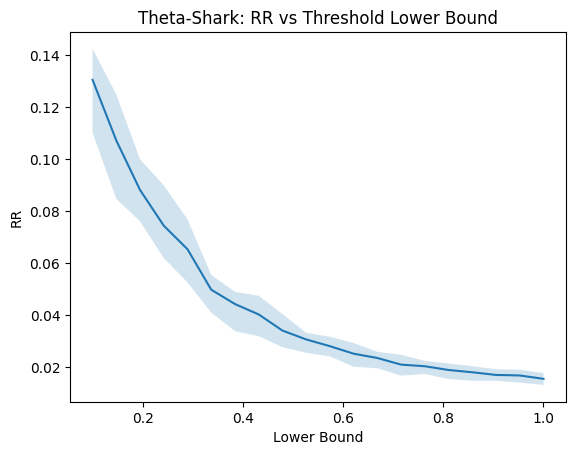

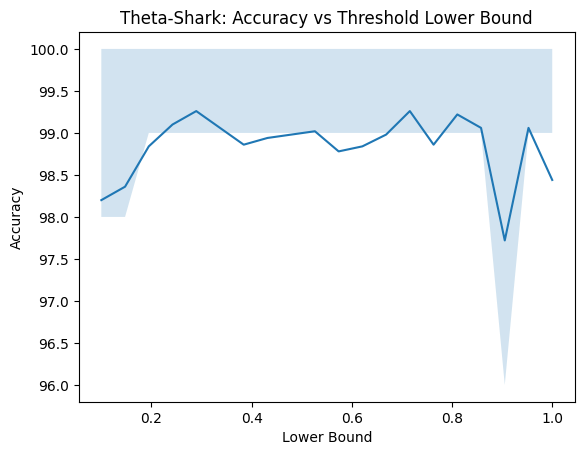

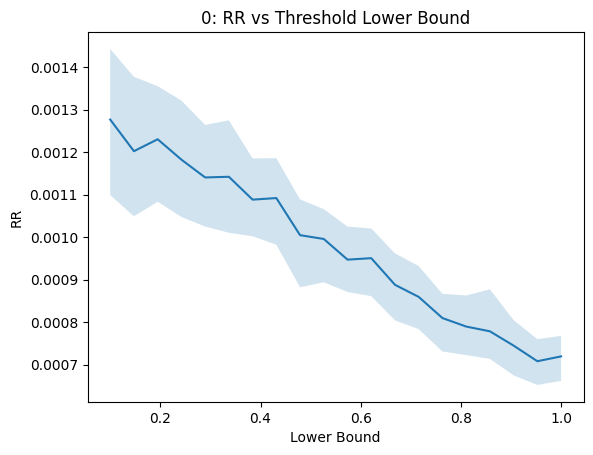

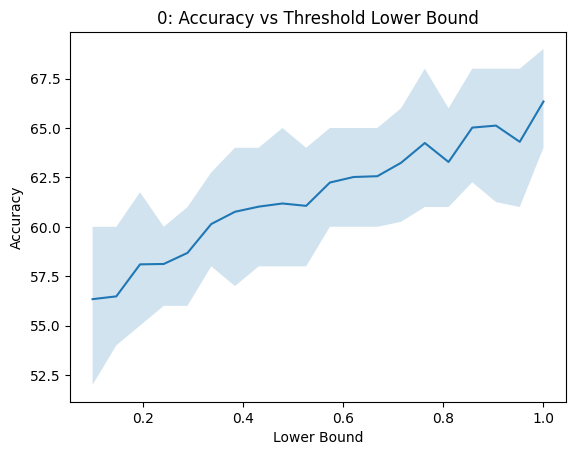

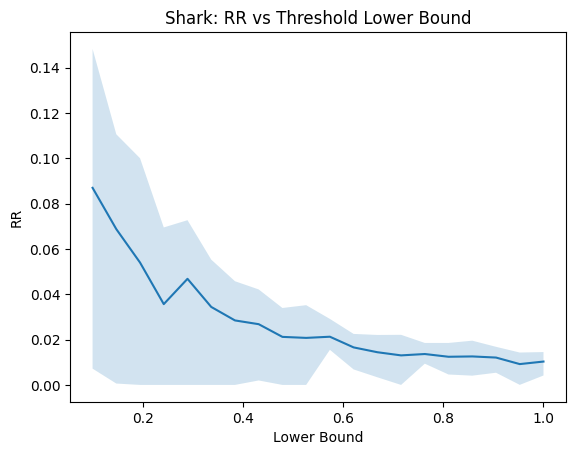

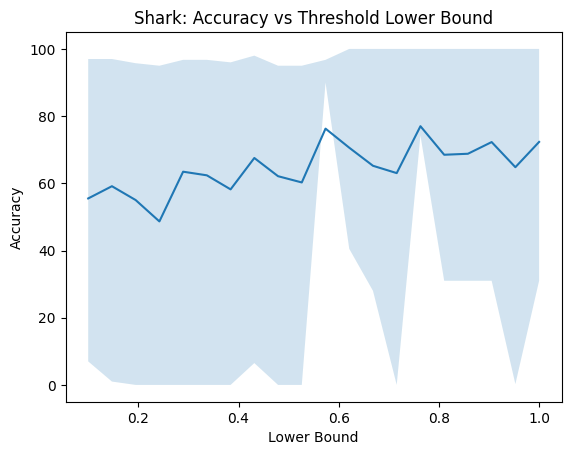

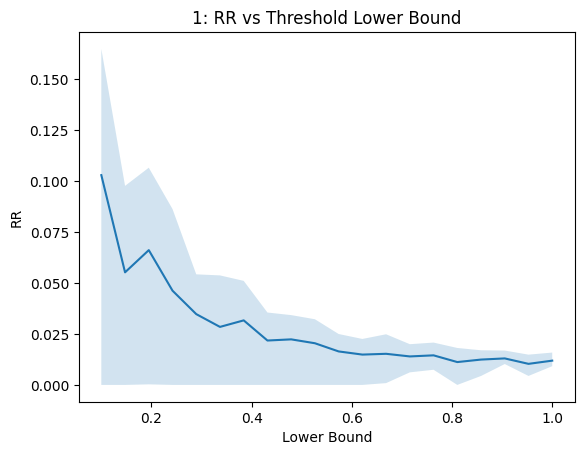

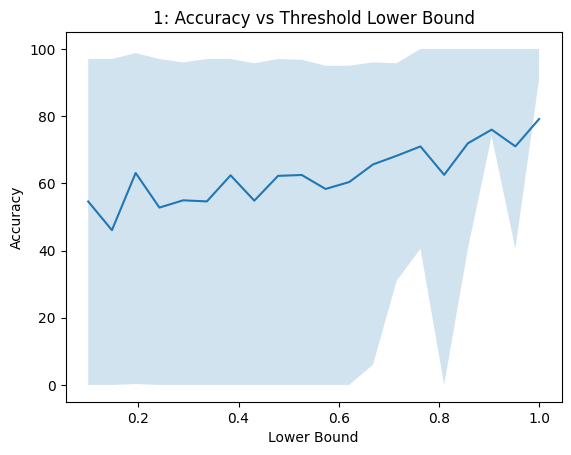

In [32]:
plotting(rr["theta"], rrm["theta"], th["theta"], "Lower Bound", "RR", "Theta-Shark: RR vs Threshold Lower Bound")
plotting(cor["theta"], corm["theta"], th["theta"], "Lower Bound", "Accuracy", "Theta-Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["0"], rrm["0"], th["0"], "Lower Bound", "RR", "0: RR vs Threshold Lower Bound")
plotting(cor["0"], corm["0"], th["0"], "Lower Bound", "Accuracy", "0: Accuracy vs Threshold Lower Bound")

plotting(rr["shark"], rrm["shark"], th["shark"], "Lower Bound", "RR", "Shark: RR vs Threshold Lower Bound")
plotting(cor["shark"], corm["shark"], th["shark"], "Lower Bound", "Accuracy", "Shark: Accuracy vs Threshold Lower Bound")

plotting(rr["1"], rrm["1"], th["1"], "Lower Bound", "RR", "1: RR vs Threshold Lower Bound")
plotting(cor["1"], corm["1"], th["1"], "Lower Bound", "Accuracy", "1: Accuracy vs Threshold Lower Bound")

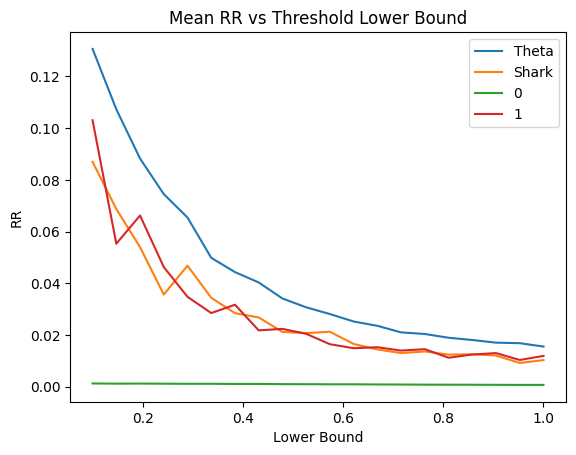

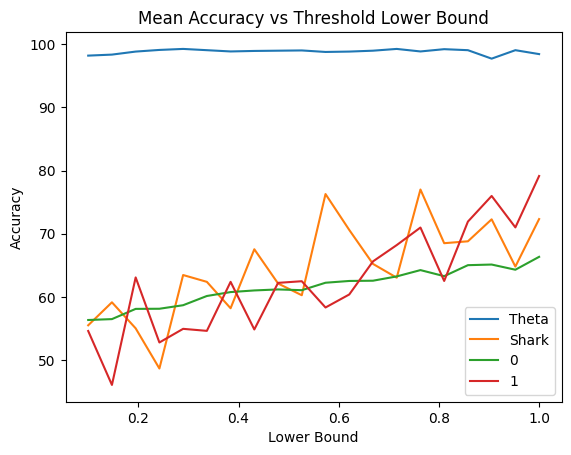

In [33]:
# plot all mean rr and acc lines
plt.plot(np.linspace(.1,1,20), rrm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), rrm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), rrm["0"], label="0")
plt.plot(np.linspace(.1,1,20), rrm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("RR")
plt.title("Mean RR vs Threshold Lower Bound")
plt.legend()
plt.show()

plt.plot(np.linspace(.1,1,20), corm["theta"], label="Theta")
plt.plot(np.linspace(.1,1,20), corm["shark"], label="Shark")
plt.plot(np.linspace(.1,1,20), corm["0"], label="0")
plt.plot(np.linspace(.1,1,20), corm["1"], label="1")
plt.xlabel("Lower Bound")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy vs Threshold Lower Bound")
plt.legend()
plt.show()
